# <font style = "color:rgb(50,120,229)">Skin Smoothing</font>

In previous modules we have seen how we can use grabcut for detecting skin region given the image of a face. The detected skin can then be smoothened and applied back to the original image, thereby resulting in a skin smoothened image. 

In this project, you will be implementing **Skin Smoothing** but this time the image will contain regions other than face as well and will have to be completely automated.

You can use the following steps to approach this problem:

1. Detect the faces in the image using Deep Learning or HAAR Cascades
2. Iterate over the detected faces and apply smoothing filter. You can experiment with the filter type and size to see which one (or combination) gives the best result.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
# Read image
img = cv2.imread(DATA_PATH + "images/hillary_clinton.jpg")

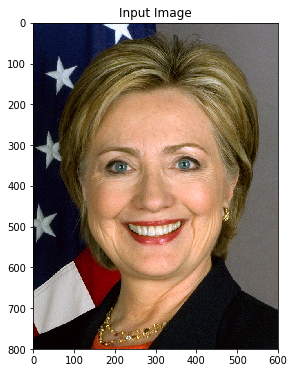

In [4]:
plt.imshow(img[:,:,::-1])
plt.title("Input Image")
plt.show()

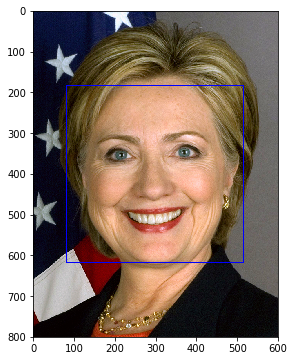

In [5]:
# Prepare HAAR Cascades
faceCascade = cv2.CascadeClassifier(DATA_PATH + 'models/haarcascade_frontalface_default.xml')

#Convert to Gray and detect faces
imcp = img.copy()
imgGray = cv2.cvtColor(imcp, cv2.COLOR_BGR2GRAY)
scaleFact = 1.2
minNeigh = 7
faces = faceCascade.detectMultiScale(imgGray, scaleFact, minNeigh)

# mark and plot the face region
plt.figure(figsize=(6,6))
x, y, w, h = faces[0]
cv2.rectangle(imcp, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.imshow(imcp[:,:,::-1])

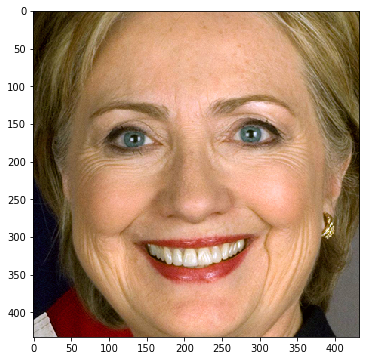

In [6]:
imgROI = img[y: y + h, x: x + w]
imgROI = imgROI[:,:,::-1]
plt.imshow(imgROI)

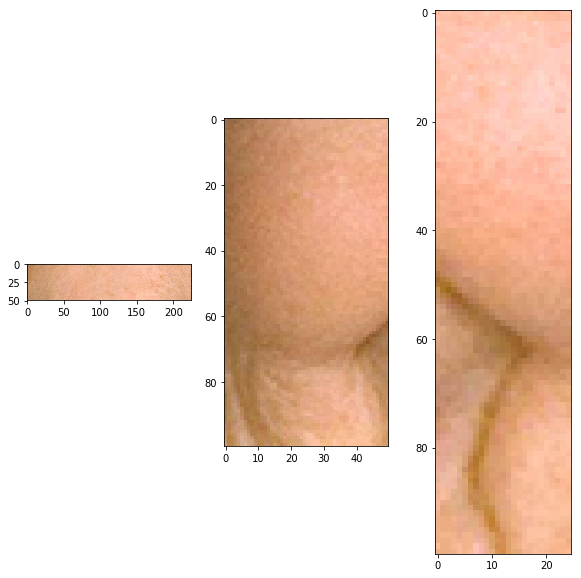

In [7]:
FHPatch  = imgROI[50:100, 100:325]
LChPatch = imgROI[225:325, 75:125]
RChPatch = imgROI[225:325, 300:325]
plt.figure(figsize=(10,10))
patches = []
patches  = np.copy(FHPatch)
plt.subplot(1,3,1)
plt.imshow(patches)
patches  = np.copy(LChPatch)
plt.subplot(1,3,2)
plt.imshow(patches)
patches  = np.copy(RChPatch) 
plt.subplot(1,3,3)
plt.imshow(patches)

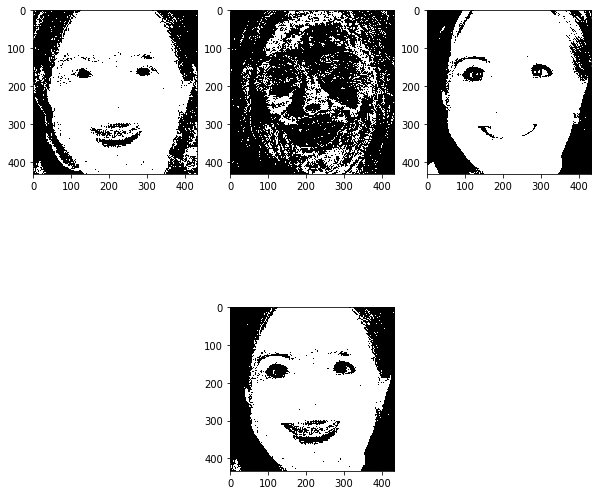

In [8]:
hsv = cv2.cvtColor(imgROI, cv2.COLOR_BGR2HSV)

fhHSV = hsv[50:100, 100:325]
lcHSV = hsv[225:325, 75:125]
rcHSV = hsv[225:325, 300:325]

fhmeanHSV = cv2.meanStdDev(fhHSV)[0]
lcmeanHSV = cv2.meanStdDev(lcHSV)[0]
rcmeanHSV = cv2.meanStdDev(rcHSV)[0]

meanHSV = (fhmeanHSV + lcmeanHSV + rcmeanHSV)/3

tolH = 6
tolS = 10
tolV = 95

minHSV = np.array([meanHSV[0] - tolH, meanHSV[1] - tolH, meanHSV[2] - tolV])
maxHSV = np.array([meanHSV[0] + tolH, meanHSV[1] + tolH, meanHSV[2] + tolV])


mask1 = cv2.inRange(hsv[:,:,0], minHSV[0], maxHSV[0])
mask2 = cv2.inRange(hsv[:,:,1], minHSV[1], maxHSV[1])
mask3 = cv2.inRange(hsv[:,:,2], minHSV[2], maxHSV[2])

plt.figure(figsize=(10,10))
patches = []
patches  = np.copy(mask1)
plt.subplot(2,3,1)
plt.imshow(patches)
patches  = np.copy(mask2)
plt.subplot(2,3,2)
plt.imshow(patches)
patches  = np.copy(mask3) 
plt.subplot(2,3,3)
plt.imshow(patches)

patches  = np.copy(mask1*mask3) 
plt.subplot(2,3,5)
plt.imshow(patches)



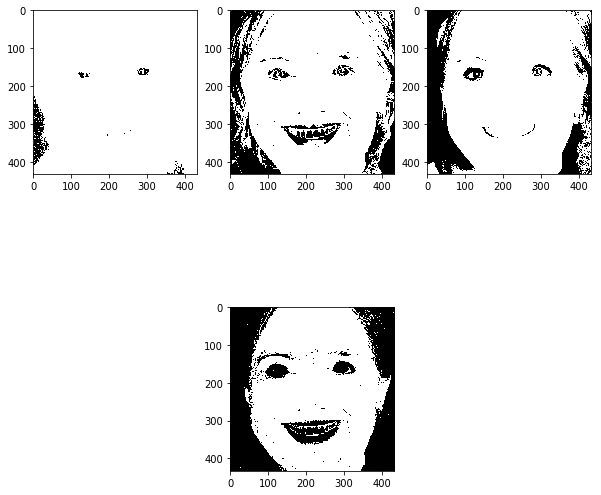

In [9]:
tolH = 60
tolS = 10
tolV = 120

minHSV = np.array([meanHSV[0] - tolH, meanHSV[1] - tolH, meanHSV[2] - tolV])
maxHSV = np.array([meanHSV[0] + tolH, meanHSV[1] + tolH, meanHSV[2] + tolV])


mask4 = cv2.inRange(hsv[:,:,0], minHSV[0], maxHSV[0])
mask5 = cv2.inRange(hsv[:,:,1], minHSV[1], maxHSV[1])
mask6 = cv2.inRange(hsv[:,:,2], minHSV[2], maxHSV[2])

plt.figure(figsize=(10,10))
patches = []
patches  = np.copy(mask4)
plt.subplot(2,3,1)
plt.imshow(patches)
patches  = np.copy(mask5)
plt.subplot(2,3,2)
plt.imshow(patches)
patches  = np.copy(mask6) 
plt.subplot(2,3,3)
plt.imshow(patches)
patches  = np.copy(mask1*mask3*mask5*mask6) # 
plt.subplot(2,3,5)
plt.imshow(patches)

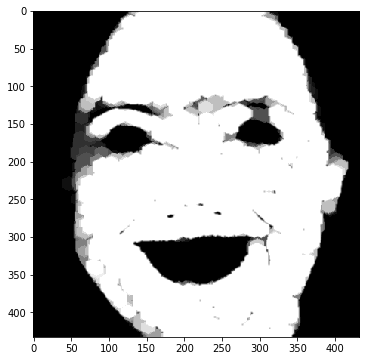

In [10]:
skinmask = mask1*mask3*mask5
#skinblur = cv2.GaussianBlur(skin, (9, 9), 0)
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

skinmask = cv2.GaussianBlur(skinmask, (3, 3), 0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

skinmask = cv2.morphologyEx(skinmask, cv2.MORPH_OPEN, kernel, iterations = 4)
nskinmask = 255 - skinmask
plt.imshow(skinmask)

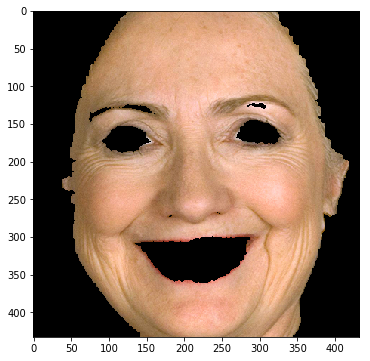

In [11]:
skinrgb = cv2.bitwise_and(imgROI, imgROI, mask = skinmask)
plt.imshow(skinrgb)

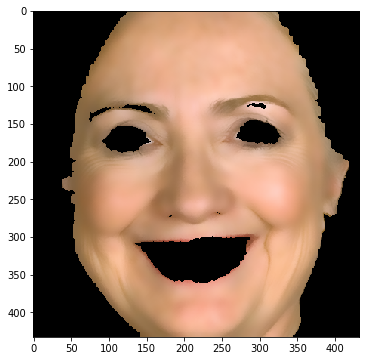

In [12]:
# diameter of the pixel neighbourhood used during filtering
dia=15;

# Larger the value the distant colours will be mixed together 
# to produce areas of semi equal colors
sigmaColor=80

# Larger the value more the influence of the farther placed pixels 
# as long as their colors are close enough
sigmaSpace=80

#Apply bilateralFilter
result = cv2.bilateralFilter(skinrgb, dia, sigmaColor, sigmaSpace)
#result[np.where(result <= [10])] = [255]
plt.imshow(result)

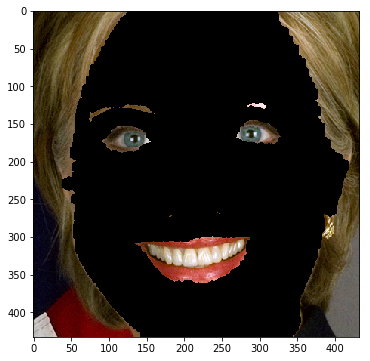

In [13]:
ret, th1 = cv2.threshold(nskinmask, 253, 255, cv2.THRESH_BINARY)
anded = cv2.bitwise_and(imgROI, imgROI, mask=th1)
plt.imshow(anded)

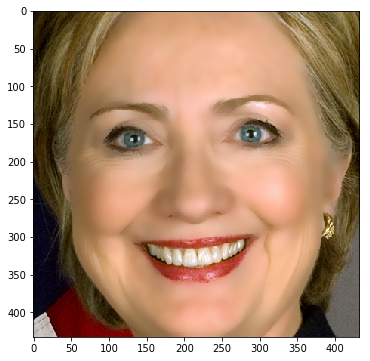

In [14]:
added = cv2.add(anded, result)
plt.imshow(added)

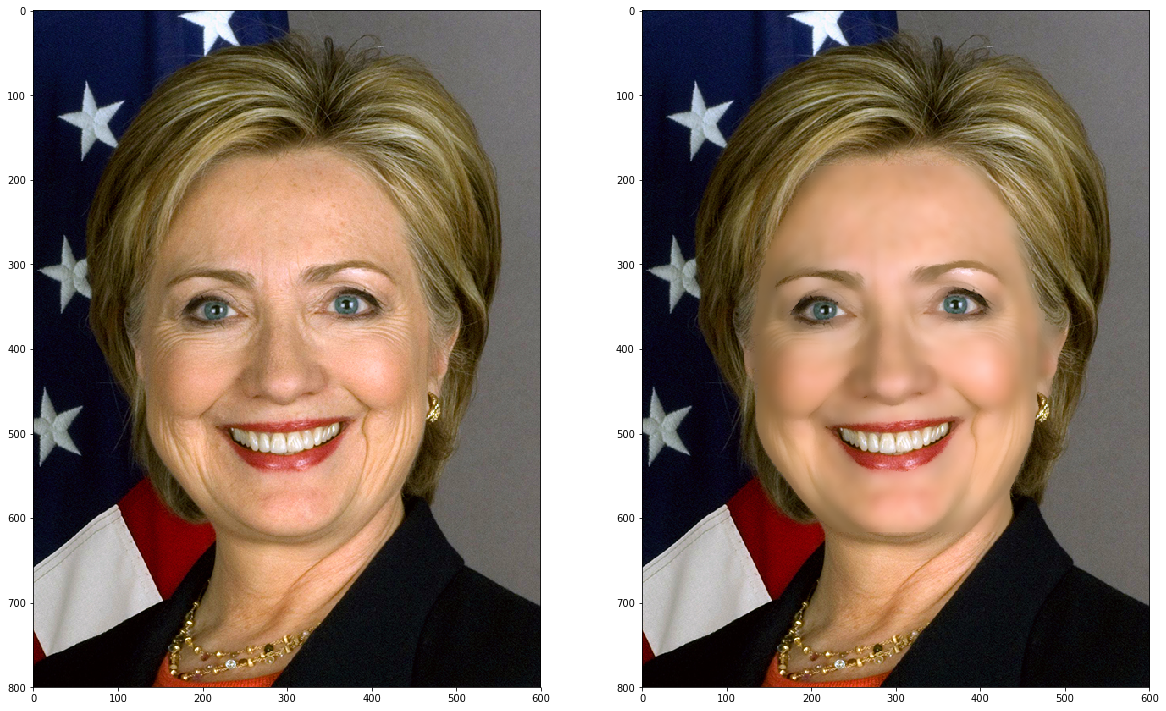

In [15]:
original = img[:,:,::-1].copy()
final = original.copy()
final[y:y+h, x:x+w] = added
plt.figure(figsize=(20,20))
patches = []
patches  = np.copy(original)
plt.subplot(1,2,1)
plt.imshow(patches)
patches  = np.copy(final)
plt.subplot(1,2,2)
plt.imshow(patches)